<a id="top"></a>
# Vegetation Change

This notebook uses changes in NDVI to identify vegetation change. The algorithm identifies a "baseline" and "analysis" time period and then compares the spectral parameters in each of those time periods. Significant reductions in vegetation are coincident with land change. In some cases these changes could be deforestation. Users of this algorithm should not accept the accuracy of the results but should conduct ground validation testing to assess accuracy. In most cases, these algorithms can be used to identify clusters of pixels that have experienced change and allow targeted investigation of those areas by local or regional governments.

## <span id="connect_dc">Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
import warnings
# Supress Warning 
warnings.filterwarnings('ignore')

import datacube
dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')

import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi(config = '/home/localuser/.datacube.conf')
dc = api.dc

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

In [2]:
# Select a Product and Platform

# product = "ls7_ledaps_ghana"
# platform = "LANDSAT_7"

product = "ls8_lasrc_ghana"
platform = "LANDSAT_8"

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [3]:
# Print extents of the data cube
extents = api.get_full_dataset_extent(platform = platform, product = product)
latitude_extents = (min(extents['latitude'].values),max(extents['latitude'].values))
longitude_extents = (min(extents['longitude'].values),max(extents['longitude'].values))
time_extents = (min(extents['time'].values),max(extents['time'].values))
print(time_extents)
print(latitude_extents)
print(longitude_extents)

(numpy.datetime64('2013-04-13T10:10:55.000000000'), numpy.datetime64('2019-02-16T10:15:26.000000000'))
(3.7730589405966173, 11.318637832619382)
(-3.772789446011382, 1.8863273493593828)


## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

In [4]:
# Select an analysis region 
# Consider using Cloud Statistics notebook to find clear scenes

# Mining Region near Obuasi, Ghana - LARGE
# Run case from 2015 (year) thru 2019 (first 3 months)
# latitude = (6.0985, 6.2675)
# longitude = (-2.050, -1.8629)

# Mining Region west of Obuasi, Ghana - SMALL
# Run case from 2015 (year) thru 2019 (first 3 months)
# latitude = (6.2286, 6.2822)
# longitude = (-1.9324, -1.8871)

# Ankobra River Basin = Prestia Sample
# Time periods = 29-Dec-2015 to Jan-2018
# latitude = (5.4458, 5.5258)
# longitude = (-2.1792, -2.0886)

# Ankobra River Basin = Entire Bounding Region
latitude = (5.198, 5.695)
longitude = (-2.275, -1.750)


In [5]:
## The code below renders a map that can be used to orient yourself with the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = latitude, longitude = longitude)

## <span id="define_analysis_params">Define Analysis Parameters [&#9652;](#top)</span>  

In [6]:
from datetime import datetime

# Select the start and end periods for your analysis products
# The datetime function is (Year,Month,Day)
# These time windows will be used to make a mosaic, so typically pick a year length or more
# Be sure to evaluate the RGB mosaics to affirm they are not full of clouds

# Select the baseline time period (start and end)
baseline_time_period = (datetime(2015,1,1), datetime(2015,12,31))

# Select the analysis time period (start and end)
analysis_time_period = (datetime(2018,1,1), datetime(2018,12,31))

# Select the cloud-free mosaic type
# Options are: max_ndvi, min_ndvi, median, most_recent_pixel, geomedian
# If a geomedian is selected, it will take much longer to process
# It is most common to use the max_ndvi or median for these land change analyses

baseline_mosaic_function = "median" 
analysis_mosaic_function = "median" 

## <span id="load_data">Load and Clean Data from the Data Cube [&#9652;](#top)</span>  

In [7]:
import datacube
name = "land change"
version = 1
dc = datacube.Datacube(app = "{}_v{}".format(name, version),config = '/home/localuser/.datacube.conf')

common_load_params = dict(latitude = latitude, longitude = longitude,
                          measurements = ["red", "green", "blue", "nir", "swir1", "swir2", "pixel_qa"],
                          product = product, platform = platform)

In [8]:
baseline_ds = dc.load(**common_load_params, time = baseline_time_period)

In [9]:
analysis_ds = dc.load(**common_load_params, time = analysis_time_period)

In [10]:
from utils.data_cube_utilities.dc_mosaic import ls8_unpack_qa, ls7_unpack_qa 

unpack_functions = {"LANDSAT_7": ls7_unpack_qa,"LANDSAT_8": ls8_unpack_qa}
unpack_function = unpack_functions[platform]

In [11]:
import numpy as np
def clean_mask(ds, unpacking_func, cover_types):
    masks = [unpacking_func(ds, cover_type) for cover_type in cover_types]
    return np.logical_or(*masks).values

In [12]:
baseline_clean_mask = clean_mask(baseline_ds.pixel_qa, unpack_function, ["clear", "water"])
analysis_clean_mask = clean_mask(analysis_ds.pixel_qa, unpack_function, ["clear", "water"])

In [13]:
baseline_ds = baseline_ds.where(baseline_clean_mask)
analysis_ds = analysis_ds.where(analysis_clean_mask)

In [14]:
# Check the dimensions of the dataset and make sure it is not empty
baseline_ds

<xarray.Dataset>
Dimensions:    (latitude: 1845, longitude: 1949, time: 25)
Coordinates:
  * time       (time) datetime64[ns] 2015-01-02T10:28:05 ... 2015-12-29T10:22:23
  * latitude   (latitude) float64 5.695 5.695 5.695 5.694 ... 5.199 5.198 5.198
  * longitude  (longitude) float64 -2.275 -2.275 -2.274 ... -1.751 -1.75 -1.75
Data variables:
    red        (time, latitude, longitude) float64 312.0 296.0 ... 1.176e+03
    green      (time, latitude, longitude) float64 427.0 405.0 ... 1.182e+03
    blue       (time, latitude, longitude) float64 244.0 234.0 ... 685.0 700.0
    nir        (time, latitude, longitude) float64 2.747e+03 ... 3.096e+03
    swir1      (time, latitude, longitude) float64 1.653e+03 ... 2.46e+03
    swir2      (time, latitude, longitude) float64 756.0 690.0 ... 1.46e+03
    pixel_qa   (time, latitude, longitude) float64 322.0 322.0 ... 322.0 322.0
Attributes:
    crs:      EPSG:4326

## Create a Mosaic for the Baseline and Analysis Time Periods

In [15]:
from utils.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_min_ndvi_mosaic, create_median_mosaic, create_mosaic, create_hdmedians_multiple_band_mosaic

mosaic_function = {"median": create_median_mosaic,
                   "max_ndvi": create_max_ndvi_mosaic,
                   "min_ndvi": create_min_ndvi_mosaic,
                   "geomedian": create_hdmedians_multiple_band_mosaic,
                   "most_recent_pixel": create_mosaic}

In [16]:
baseline_compositor = mosaic_function[baseline_mosaic_function]
analysis_compositor = mosaic_function[analysis_mosaic_function]

In [17]:
baseline_composite = baseline_compositor(baseline_ds, clean_mask = baseline_clean_mask)
analysis_composite = analysis_compositor(analysis_ds, clean_mask = analysis_clean_mask)

## Shapefile Masking

In [18]:
SHAPE_FILE_PATH = "data/Ghana/Prestea.shp"

In [19]:
import fiona
import xarray as xr 
from rasterio.features import geometry_mask
import shapely
from shapely.ops import transform
from shapely.geometry import shape
from functools import partial
import pyproj

def shapefile_mask(dataset: xr.Dataset, shapefile) -> np.array:
    """Extracts a mask from a shapefile using dataset latitude and longitude extents.

    Args:
        dataset (xarray.Dataset): The dataset with the latitude and longitude extents.
        shapefile (string): The shapefile to be used for extraction.

    Returns:
        A boolean mask array.
    """
    with fiona.open(shapefile, 'r') as source:
        collection = list(source)
        geometries = []
        for feature in collection:
            geom = shape(feature['geometry'])
            project = partial(
                pyproj.transform,
                pyproj.Proj(init=source.crs['init']), # source crs
                pyproj.Proj(init='epsg:4326')) # destination crs
            geom = transform(project, geom)  # apply projection
            geometries.append(geom)
        geobox = dataset.geobox
        mask = geometry_mask(
            geometries,
            out_shape=geobox.shape,
            transform=geobox.affine,
            all_touched=True,
            invert=True)
    return mask

In [20]:
mask = shapefile_mask(baseline_ds, SHAPE_FILE_PATH)

In [21]:
baseline_composite = baseline_composite.where(mask)
analysis_composite = analysis_composite.where(mask)

## <span id="anomalies">Calculate Anomaly Product [&#9652;](#top)</span>  

In [24]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

In [25]:
from utils.data_cube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify 
parameter_baseline_composite = NDVI(baseline_composite)
parameter_analysis_composite = NDVI(analysis_composite)
parameter_anomaly = parameter_analysis_composite - parameter_baseline_composite

## Show Baseline RGB, Analysis RGB and Anomaly Products

In [26]:
import matplotlib.pyplot as plt
from utils.data_cube_utilities.dc_rgb import rgb
from matplotlib.cm import RdYlGn
RdYlGn.set_bad('black',1.)

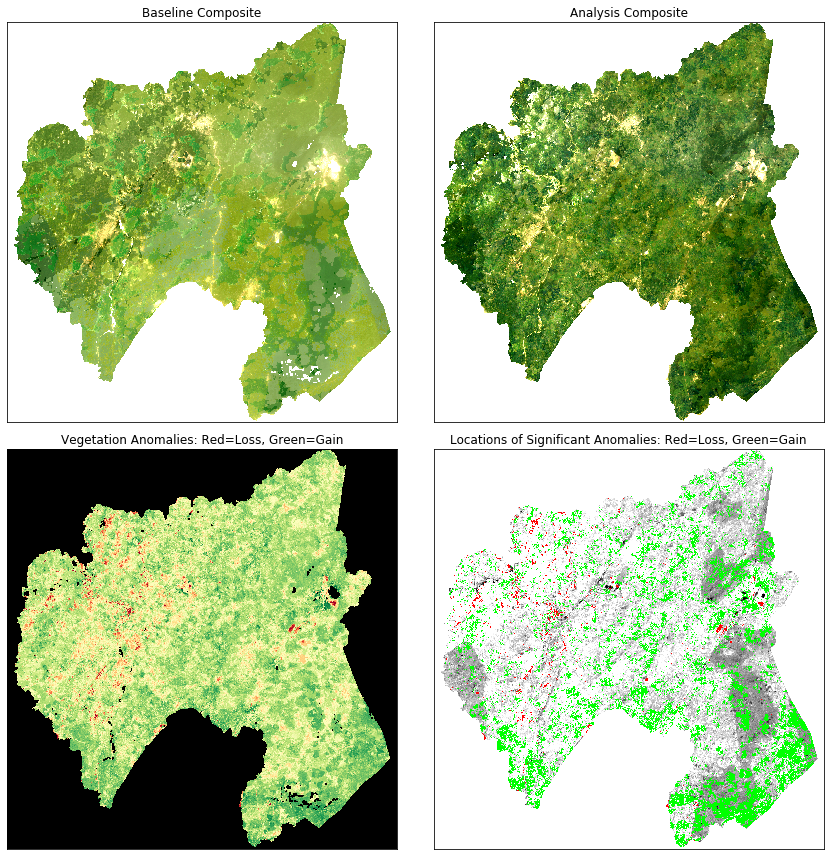

In [27]:
import xarray as xr

fig, ax = plt.subplots(2, 2, figsize=(12,12))

baseline_rgb = baseline_composite[['red', 'green', 'blue']].to_array()
analysis_rgb = analysis_composite[['red', 'green', 'blue']].to_array()

# Use the middle values of the data (2% to 98%) to brighten the image
lw_qtl, up_qtl = 0.02, 0.98
rgb_vmin = min(baseline_rgb.quantile(lw_qtl).values,analysis_rgb.quantile(lw_qtl).values)
rgb_vmax = max(baseline_rgb.quantile(up_qtl).values,analysis_rgb.quantile(up_qtl).values)

# Plot the resulting 4 products ... Baseline RGB, Analysis RGB, Total Anomaly, Anomaly Threshold

## Plot #1 = Baseline RGB (upper left)
baseline_rgb.plot.imshow(ax=ax[0,0], vmin=rgb_vmin, vmax=rgb_vmax)

## Plot #2 = Analysis RGB (upper right)
analysis_rgb.plot.imshow(ax=ax[0,1], vmin=rgb_vmin, vmax=rgb_vmax)

## Plot #3 = Total Anomaly (lower left)
parameter_anomaly.plot(ax=ax[1,0], vmin=-0.4, vmax=0.4, cmap = RdYlGn, add_colorbar=False)

## Plot #4 = Anomaly Threshold (lower right)

# Analysis composite grayscale background
plt4_bkg_band = 'swir1' # The band to use as the background image.
plt4_rgb = np.repeat(analysis_composite[plt4_bkg_band].values[:,:,np.newaxis],3,axis=2)

# Selected a range of SWIR1 values (0.001 to 0.600) to lighten image background (vs. 0.02 and 0.98)
min_bkg = np.nanquantile(analysis_composite[plt4_bkg_band].values, 0.001)
max_bkg = np.nanquantile(analysis_composite[plt4_bkg_band].values, 0.600)
plt4_rgb = np.interp(plt4_rgb, (min_bkg, max_bkg), [0,1])

# Extreme anomaly overlays
loss_range  = parameter_anomaly < -0.2
gain_range  = parameter_anomaly > 0.2
color_green = np.array([0,1,0]) # green
color_red   = np.array([1,0,0]) # red
plt4_rgb[loss_range] = color_red
plt4_rgb[gain_range] = color_green

# Plot
plt4_coords = dict(analysis_composite.coords)
rgb_coord_arr = np.array(['red', 'green', 'blue'])
rgb_coord_da = xr.DataArray(rgb_coord_arr,name='rgb',dims=['rgb'],coords={'rgb': rgb_coord_arr})
plt4_coords.update({'rgb': rgb_coord_da})
plt4_rgb_da = xr.DataArray(plt4_rgb, coords=plt4_coords,dims=list(analysis_composite.dims) + ['rgb'])
plt4_rgb_da.plot.imshow(ax=ax[1,1])

# Titles for all plots
ax[0,0].set_title('Baseline Composite'), ax[0,0].xaxis.set_visible(False), ax[0,0].yaxis.set_visible(False)
ax[0,1].set_title('Analysis Composite'), ax[0,1].xaxis.set_visible(False), ax[0,1].yaxis.set_visible(False)
ax[1,0].set_title('Vegetation Anomalies: Red=Loss, Green=Gain'), ax[1,0].xaxis.set_visible(False), ax[1,0].yaxis.set_visible(False)
ax[1,1].set_title('Locations of Significant Anomalies: Red=Loss, Green=Gain'), ax[1,1].xaxis.set_visible(False), ax[1,1].yaxis.set_visible(False)

plt.tight_layout()
plt.show()

## Calculate Pixel Counts within Thresholds

In [28]:
def threshold_count(da, min_threshold, max_threshold, mask = None):
    def count_not_nans(arr):
        return np.count_nonzero(~np.isnan(arr))
    
    in_threshold = np.logical_and( da.values > min_threshold, da.values < max_threshold)
    
    total_non_cloudy = count_not_nans(da.values) if mask is None else np.sum(mask) 
    
    return dict(total = np.size(da.values),
                total_non_cloudy = total_non_cloudy,
                inside = np.nansum(in_threshold),
                outside = total_non_cloudy - np.nansum(in_threshold)
               )    
    
def threshold_percentage(da, min_threshold, max_threshold, mask = None):
    counts = threshold_count(da, min_threshold, max_threshold, mask = mask)
    return dict(percent_inside_threshold = (counts["inside"]   / counts["total"]) * 100.0,
                percent_outside_threshold = (counts["outside"] / counts["total"]) * 100.0,
                percent_clouds = ( 100.0-counts["total_non_cloudy"] / counts["total"] * 100.0))


In [29]:
# Select an Anomaly Threshold Range to calculate the results from the previous image
# Be sure to put the smallest value in the "minimum_change" location (be careful of negative values)

# NDVI losses are typically <0.2 for deforestation

minimum_change = -0.7
maximum_change = -0.2

In [30]:
# This output is a count of the pixels that fall within each threshold range

threshold_count(parameter_anomaly,minimum_change,maximum_change)

{'total': 3595905,
 'total_non_cloudy': 2021599,
 'inside': 19444,
 'outside': 2002155}

In [31]:
# This output is a percentage of the pixels that fall within each threshold range

threshold_percentage(parameter_anomaly,minimum_change,maximum_change)

{'percent_inside_threshold': 0.540726187148993,
 'percent_outside_threshold': 55.67875124620924,
 'percent_clouds': 43.78052256664178}

### GeoTIFF Output Products

In [32]:
from utils_special.data_cube_utilities.import_export import export_xarray_to_geotiff

# Remove the comment to create a GeoTIFF output product
# Change the name of the output file, or it will be overwritten for each run 

export_xarray_to_geotiff(data=parameter_anomaly, tif_path='geotiffs/ndvi_anomaly_case1.tif')

In [33]:
ls -lah geotiffs/*.tif

-rw-rw-r-- 1 localuser localuser 927K Jan 16 14:10 geotiffs/DEMO_median_composite.tif
-rw-rw-r-- 1 localuser localuser  20M Mar 22 16:44 geotiffs/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_12_10.tif
-rw-rw-r-- 1 localuser localuser  19M Mar 22 16:43 geotiffs/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_12_9.tif
-rw-rw-r-- 1 localuser localuser  24M Feb 12 19:03 geotiffs/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_13_11.tif
-rw-rw-r-- 1 localuser localuser  19M Mar 22 16:43 geotiffs/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_16_11.tif
-rw-rw-r-- 1 localuser localuser  20M Mar 22 16:44 geotiffs/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_16_12.tif
-rw-rw-r-- 1 localuser localuser 833M Apr 14  2019 geotiffs/WOFS_Percentage_L-BIG_AC.tif
-rw-rw-r-- 1 localuser localuser 123M Apr 11  2019 geotiffs/WOFS_Percentage_L-Turkana_AC.tif
-rw-rw-r-- 1 localuser localuser  53M Apr 11  2019 geotiffs/WOFS_Percentage_L-Victoria_AC.tif
-rw-rw-r-- 1 localuser localuser 374K Aug 30  2019 geotiffs/WOFS_Percentage_Mom